In [1]:
import pandas as pd
import pathlib
import prophet
import numpy as np

In [2]:
DATA_DIR = pathlib.Path('../Coding Challenge - Data(20221128)')
PREDICTION_LENGTH = 31 # January has 31 days

stores_df = pd.read_csv(DATA_DIR / 'stores.csv')
transactions_df = pd.read_csv(DATA_DIR / 'transactions.csv')
users_df = pd.read_csv(DATA_DIR / 'users.csv')
dataframe = transactions_df.merge(users_df, left_on='user_id', right_on='id', how='left').merge(
    stores_df, left_on='store_id', right_on='id', how='left').drop(columns=['id_x', 'id_y', 'id'])

# Drop columns that are not used in this analysis
dataframe = dataframe.drop(columns=['lat', 'lon'])

# Convert date columns to datetime
dataframe['event_occurrence'] = pd.to_datetime(dataframe['event_occurrence'])
# Convert categorical columns to category
category_columns = ['gender', 'category', 'nam', 'laa']
for column in category_columns:
    dataframe[column] = dataframe[column].astype('category')

dataframe.head()

,user_id,store_id,event_occurrence,amount,gender,age,nam,laa,category
0,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,M,88.0,Saitama Ken,Soka Shi,コンビニ
1,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,M,44.0,Gunma Ken,Meiwa Cho,ショッピング
2,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,M,16.0,Hiroshima Ken,Fukuyama Shi,コンビニ
3,786fcb82-40cf-1dc9-b9ba-2541502ca95a,eaf4c05d-13e1-7c8a-9ae0-cf2ec2e3dcd2,2020-01-01 07:07:26.029685,166,F,79.0,Tokyo To,Nerima Ku,グルメ
4,acc814f5-beb6-db35-64f1-52f7c5a8466c,a8301ae2-df3b-ffe4-0279-c74af1dbb847,2020-01-01 07:12:24.448015,656,F,79.0,Tokyo To,Edogawa Ku,スーパーマーケット


In [3]:
# Aggregate the data by day
daily_user_df = dataframe.groupby(['user_id', pd.Grouper(
    key='event_occurrence', freq='D')])['amount'].sum().reset_index()
daily_user_df.head()

,user_id,event_occurrence,amount
0,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-11-30,309
1,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-03,502
2,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-04,1498
3,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-13,164
4,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-19,1952


In [4]:
# Train models by user
users = daily_user_df['user_id'].unique()
# TODO remove, for faster testing, pick only random 10 users
users_sample = np.random.choice(users, 10)
user_models = {}
for user in users_sample:
    user_data = daily_user_df[daily_user_df['user_id'] == user][[
        'event_occurrence', 'amount']].rename(columns={'event_occurrence': 'ds', 'amount': 'y'})
    model = prophet.Prophet()
    model.fit(user_data)
    user_models[user] = model


11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing
11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:37 - cmdstanpy - INFO - Chain [1] done processing
11:37:37 - cmdstanpy - INFO - Chain [1] start processing
11:37:37 - cmdstanpy - INFO - Chain [1] done processing
11:37:37 - cmdstanpy - INFO - Chain [1] start processing
11:37:37 - cmdstanpy - INFO - Chain [1] done processing
11:37:37 - cmdstanpy - INFO - Chain [1] start processing
11:37:37 - cmdstanpy - INFO - Chain [1] done processing
11:37:37 - cmdstanpy - INFO - Chain [1] start processing
11:37:37 - cmdstanpy - INFO - Chain [1] done processing
11:37:37 - cmdstanpy - INFO - Chain [1] start processing
11:37:37 - cmdstanpy - INFO - Chain [1] done processing
11:37:37 - cmdstanpy - INFO - Chain [1] start processing
11:37:38 - cmdstanpy - INFO - Chain [1] done processing
11:37:38 - cmdstanpy - INFO - Chain [1] start processing
11:37:38 - cmdstanpy - INFO - Chain [1]

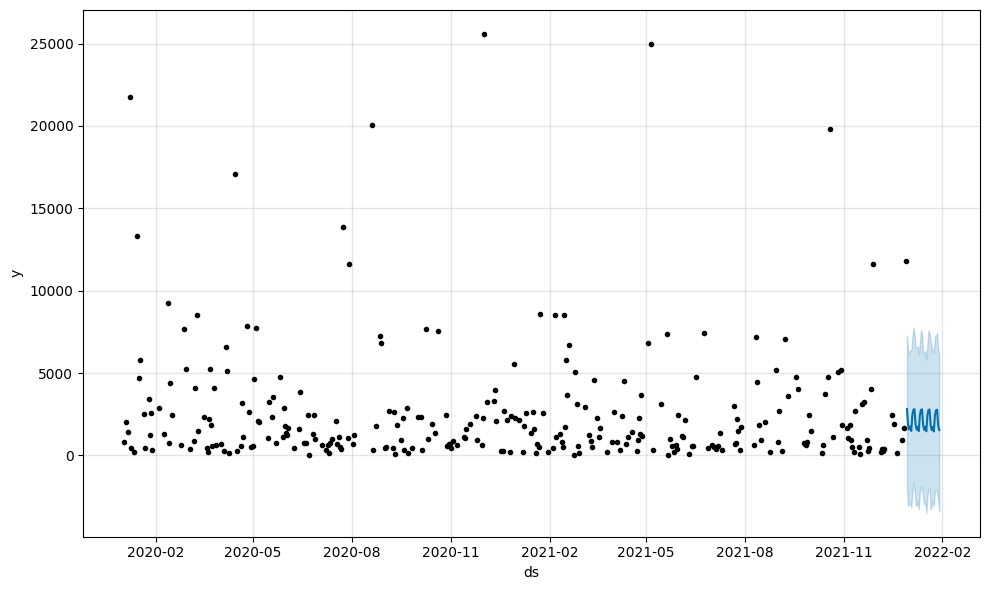

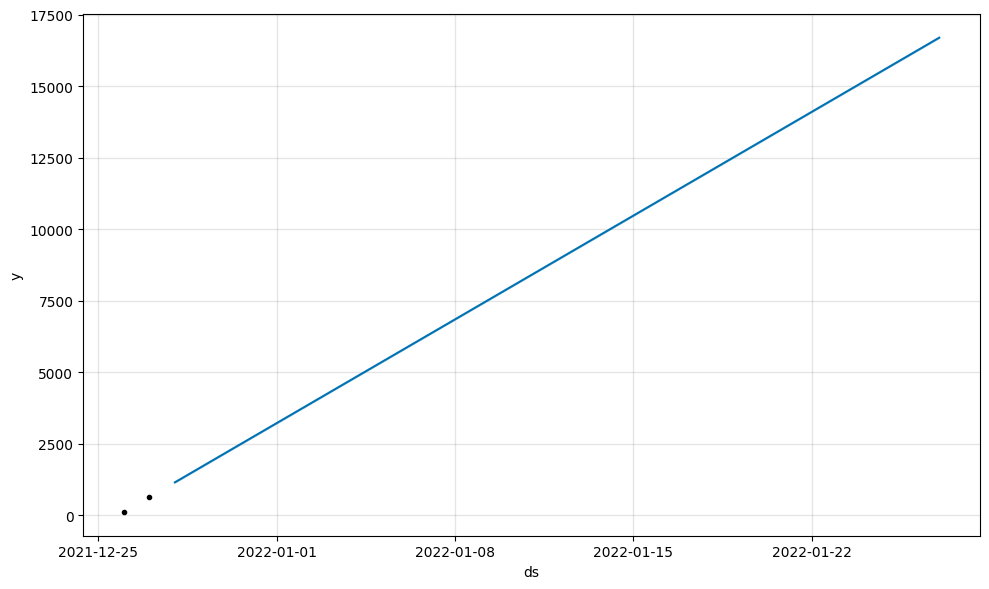

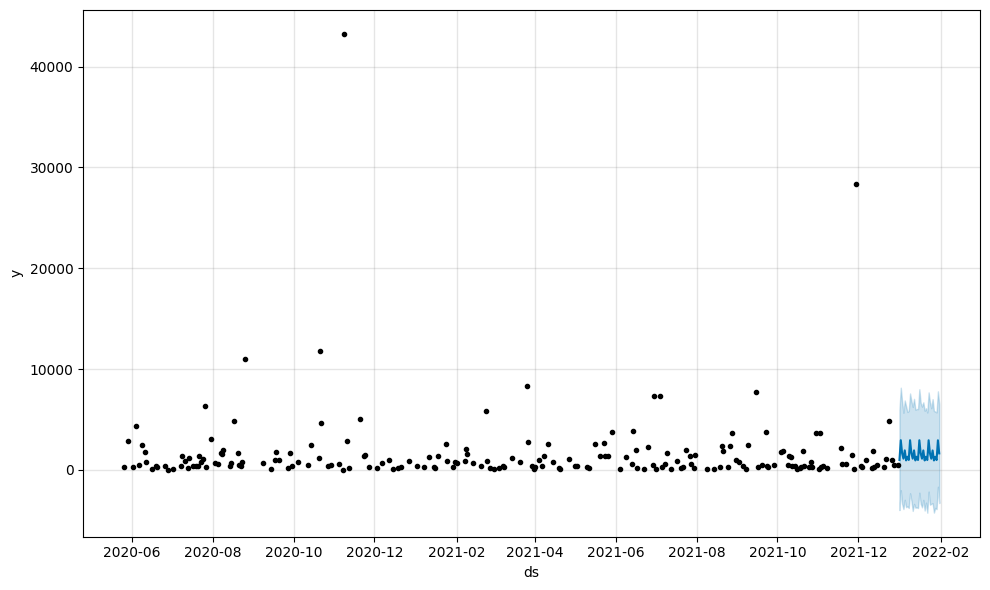

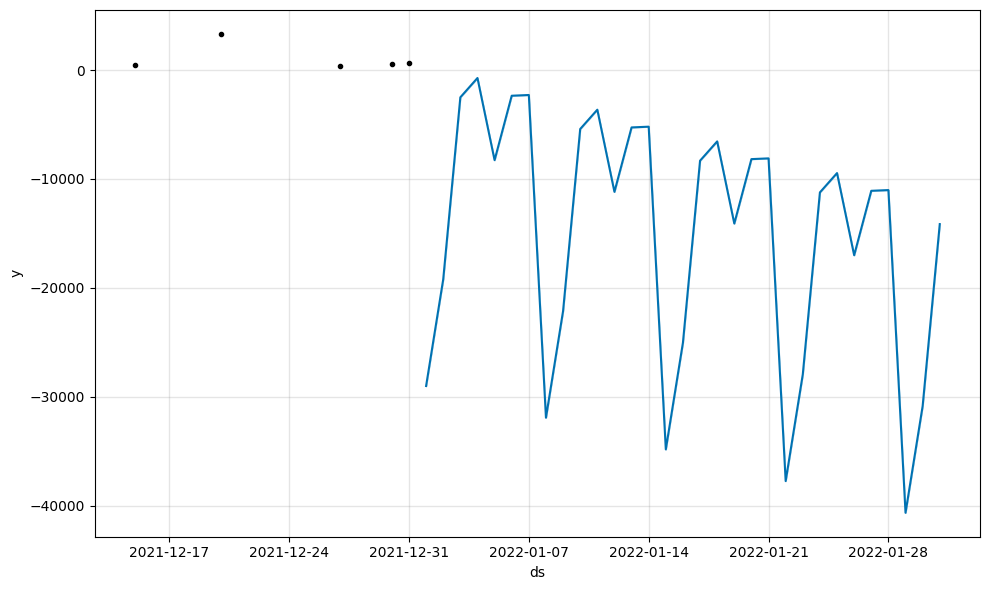

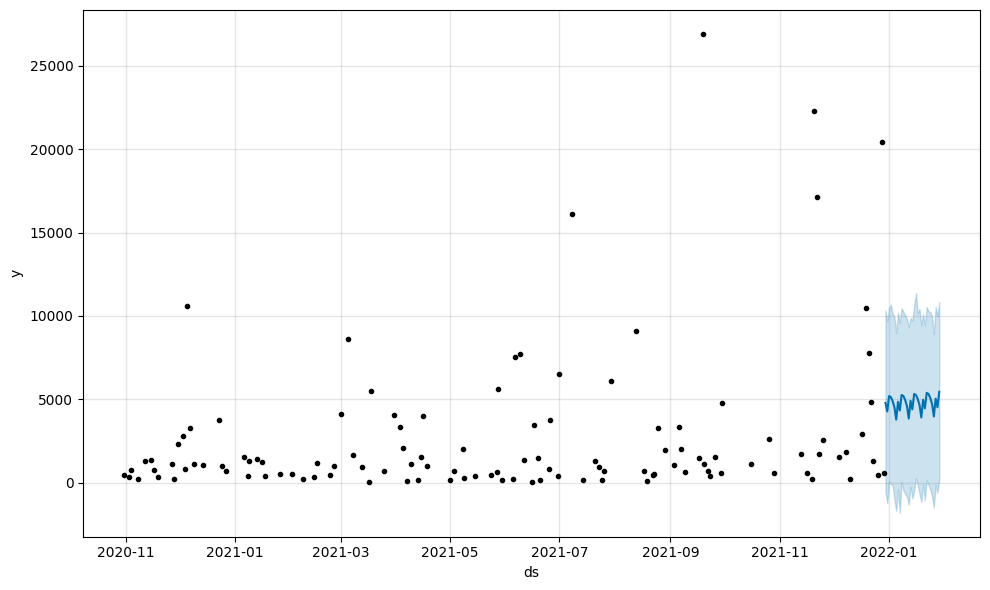

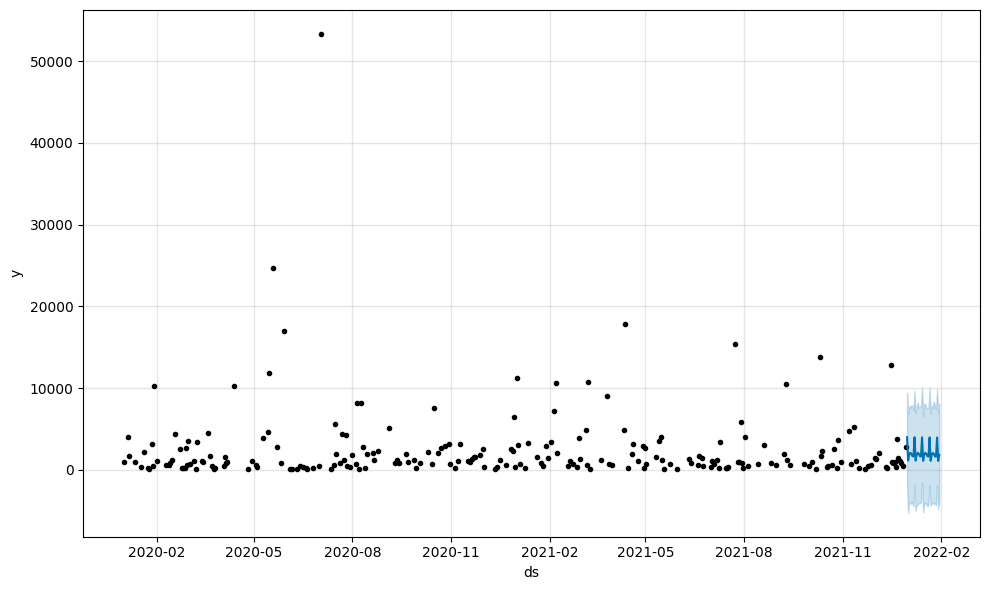

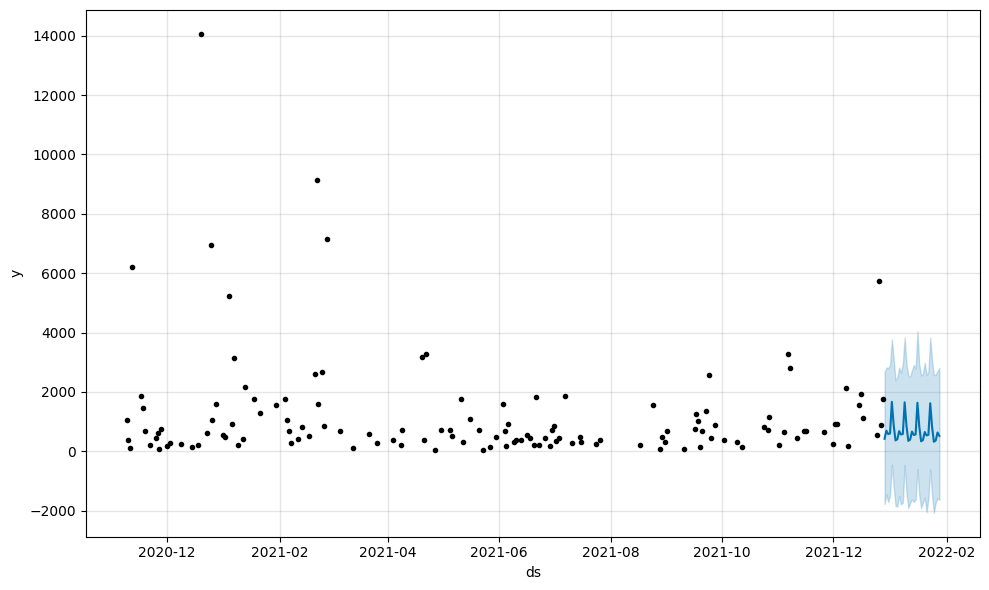

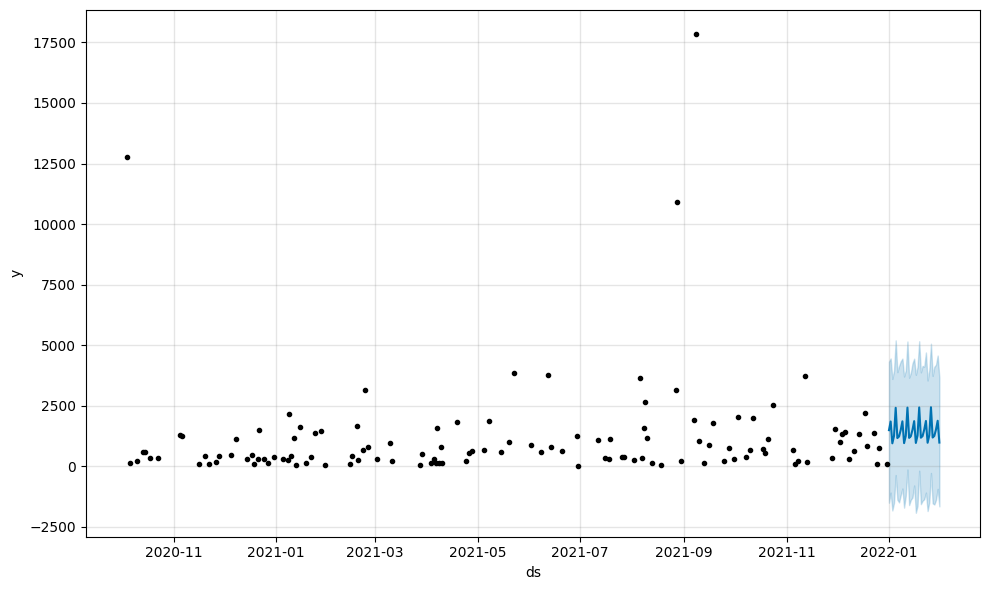

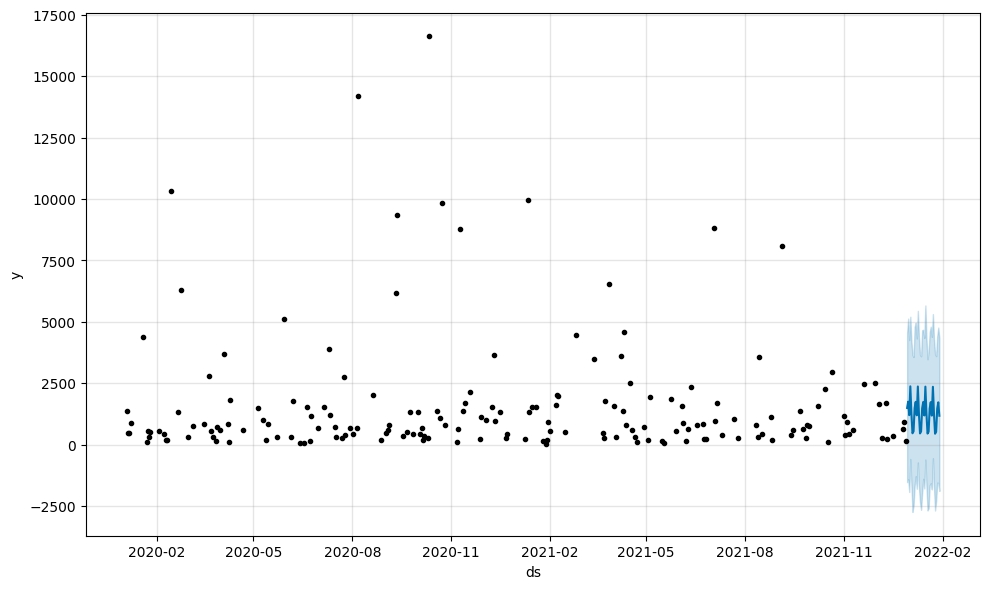

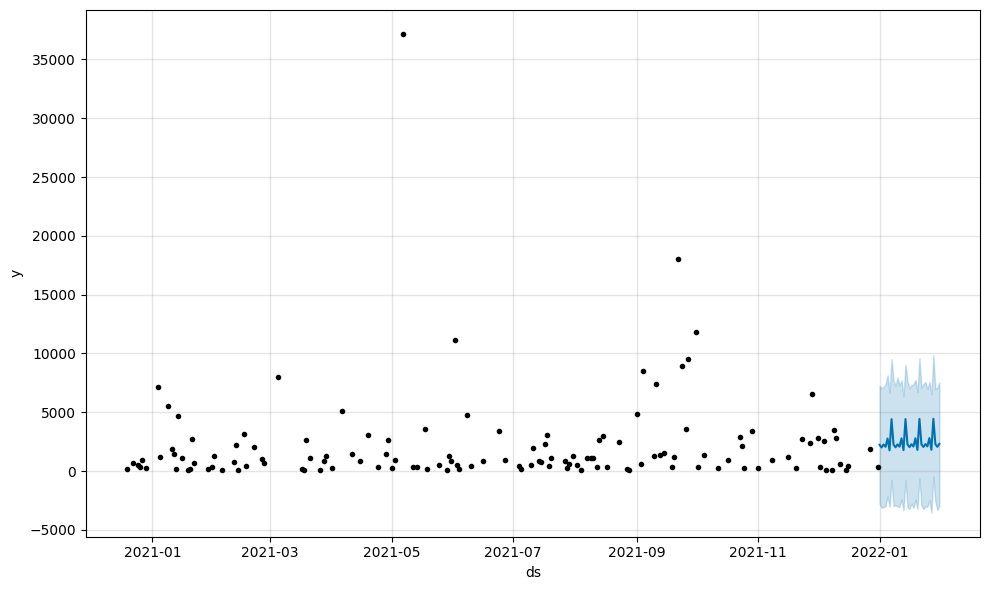

In [27]:
for user in users_sample:
    model = user_models[user]
    future_dates = model.make_future_dataframe(periods=PREDICTION_LENGTH)
    forecast = model.predict(future_dates)
    predictions = forecast.tail(PREDICTION_LENGTH)
    model.plot(predictions)


In [22]:
import logging
from tqdm.notebook import tqdm
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Train and forecast for all users
user_forecasts = {}
for user in tqdm(users):
    user_data = daily_user_df[daily_user_df['user_id'] == user][[
        'event_occurrence', 'amount']].rename(columns={'event_occurrence': 'ds', 'amount': 'y'})
    if user_data.shape[0] < 30:
        tqdm.write(
            f'WARNING User {user} has less than 30 days of data, skipping')
        user_forecasts[user] = "NaN"
        continue
    model = prophet.Prophet()
    model.fit(user_data, )
    future_dates = model.make_future_dataframe(periods=30)
    forecast = model.predict(future_dates)
    predictions = forecast[['ds', 'yhat']].tail(PREDICTION_LENGTH)
    
    # Aggregate predictions over the month
    gmv_prediction = predictions['yhat'].sum()
    tqdm.write(f'User {user} will spend {gmv_prediction} in January')
    # round to 1 decimal places
    user_forecasts[user] = gmv_prediction.round(1)
    
# Save predictions to CSV
by_user_df = pd.DataFrame.from_dict(user_forecasts, orient='index', columns=['january_gmv']).rename_axis('user_id')
by_user_df.to_csv(DATA_DIR / 'user_predictions.csv')

  0%|          | 0/9542 [00:00<?, ?it/s]

User 00073cc2-c801-c67c-d039-fca63c78c6a9 will spend 55781.617890132846 in January
User 000b6710-f8b4-ddd4-1913-90c7d424fccf will spend 80317.59774362994 in January
User 00183cfe-ceb0-9220-7984-f33f61c61ae4 will spend 88887.5643106527 in January
User 001b10c4-0ec1-68c9-a059-0a44159119bd will spend 71810.83435206342 in January
WARNING User 001cfd71-1996-2ffe-d382-4e7cd476ef88 has less than 30 days of data, skipping
User 0021b632-3246-b7d9-bb29-66398e4a295d will spend 69855.56375781102 in January
User 002b2f92-8dc5-7bd9-6689-ef79f8c3c461 will spend 44117.46695691312 in January
User 002f9cc4-096b-faff-f5b7-751f497e28aa will spend 118330.4077280373 in January
User 0030f3fb-01f7-1027-555c-7e9f7a793d3e will spend 113396.85546090455 in January
WARNING User 003c6ab8-2d19-8cf0-8d43-8259815f9e34 has less than 30 days of data, skipping
WARNING User 0042d740-0c34-a39f-ed44-e0f06a9e72f8 has less than 30 days of data, skipping
User 00513063-020a-ca12-055d-fed45fa7cb00 will spend 62060.38419525546 in

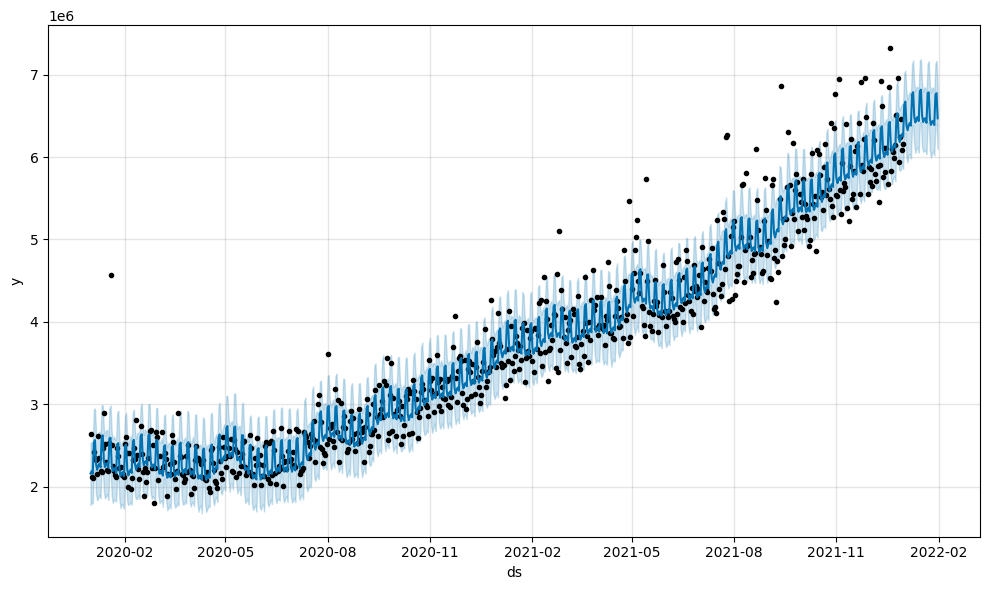

In [41]:
# Aggregate the data by day
daily_yayyay_df = dataframe.groupby([pd.Grouper(
    key='event_occurrence', freq='D')])['amount'].sum().reset_index()
daily_yayyay_df.head()

daily_data = daily_yayyay_df[[
    'event_occurrence', 'amount']].rename(columns={'event_occurrence': 'ds', 'amount': 'y'})
model = prophet.Prophet()
model.fit(daily_data)
future_dates = model.make_future_dataframe(periods=PREDICTION_LENGTH)
forecast = model.predict(future_dates)
model.plot(forecast)

# Save predictions to CSV
results = forecast[['ds', 'yhat']].tail(PREDICTION_LENGTH).rename(columns={'yhat': 'daily_gmv', 'ds': 'date'})
results['daily_gmv'] = results['daily_gmv'].round(1)
results.to_csv(DATA_DIR / 'yayyay_daily_predictions.csv', index=False)
